# Лабораторная работа 7. Методы отбора признаков

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.datasets import load_iris, load_wine, fetch_california_housing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

from scipy.stats import spearmanr

from matplotlib import pyplot

## Корреляционные методы отбора признаков.
### Задание 1. Работа с корреляционной матрицей.

Используйте набор данных "Iris" из sklearn.datasets. Вычислите корреляционную матрицу числовых признаков. Затем визуализируйте эту матрицу с помощью heatmap в библиотеке seaborn.

In [2]:
ds_iris = load_iris()

df_iris = pd.DataFrame(data=ds_iris.data, columns=ds_iris.feature_names)

df_iris.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3


In [3]:
df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [4]:
df_iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
df_iris.isna().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64

In [6]:
def anomalies_to_mean(df):
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1 

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df[col] = df[col].apply(lambda x: df[col].mean() if x < lower_bound or x > upper_bound else x)

anomalies_to_mean(df_iris)

df_iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.040862,3.758000,1.199333
std,0.828066,0.392486,1.765298,0.762238
min,4.300000,2.200000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.000000,6.900000,2.500000


In [7]:
print('Матрица корреляции: \n', df_iris.corr())

Матрица корреляции: 
                    sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.123051           0.871754   
sepal width (cm)           -0.123051          1.000000          -0.400165   
petal length (cm)           0.871754         -0.400165           1.000000   
petal width (cm)            0.817941         -0.335913           0.962865   

                   petal width (cm)  
sepal length (cm)          0.817941  
sepal width (cm)          -0.335913  
petal length (cm)          0.962865  
petal width (cm)           1.000000  


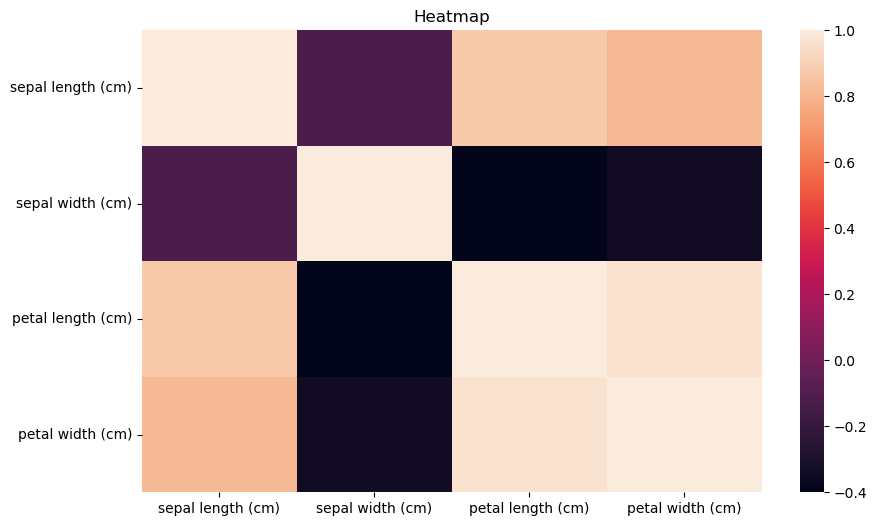

In [8]:
plt.figure(figsize=(10,6))

sns.heatmap(df_iris.corr())
plt.title('Heatmap')
plt.show()

### Задание 2. Исключение мультиколлинеарных признаков.
Используйте набор данных "Wine" из sklearn.datasets. Вычислите корреляционную матрицу, а затем найдите и исключите признаки, у которых корреляция друг с другом превышает заданный порог.

In [9]:
ds_wine = load_wine()

df_wine = pd.DataFrame(data=ds_wine.data, columns=ds_wine.feature_names)

df_wine.head(7)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0


In [10]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [11]:
df_wine.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

In [12]:
df_wine.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [13]:
anomalies_to_mean(df_wine)

df_wine.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.280444,2.362526,19.384718,98.679586,2.295112,2.029270,0.361854,1.570235,4.912036,0.953222,2.611685,746.893258
std,0.811827,1.028666,0.247381,3.025508,12.246509,0.625851,0.998859,0.124453,0.537302,2.092561,0.221421,0.709990,314.907474
min,11.030000,0.740000,1.700000,11.200000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.212500,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.494944,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.960000,2.780000,673.500000
75%,13.677500,2.982500,2.540000,21.500000,106.000000,2.800000,2.875000,0.437500,1.942500,6.000000,1.120000,3.170000,985.000000
max,14.830000,5.190000,2.920000,27.000000,134.000000,3.880000,5.080000,0.660000,2.960000,10.520000,1.450000,4.000000,1680.000000


In [14]:
df_wine_corr = df_wine.corr()

print('Матрица корреляции: \n', df_wine_corr)

Матрица корреляции: 
                                alcohol  malic_acid       ash  \
alcohol                       1.000000    0.095561  0.250555   
malic_acid                    0.095561    1.000000  0.169181   
ash                           0.250555    0.169181  1.000000   
alcalinity_of_ash            -0.300168    0.291693  0.333776   
magnesium                     0.371675    0.042627  0.366929   
total_phenols                 0.289101   -0.341916  0.093151   
flavanoids                    0.236815   -0.407380  0.021109   
nonflavanoid_phenols         -0.155929    0.266950  0.157336   
proanthocyanins               0.196917   -0.252853 -0.003336   
color_intensity               0.554875    0.295844  0.217374   
hue                          -0.027454   -0.558425 -0.076001   
od280/od315_of_diluted_wines  0.072343   -0.368537 -0.067397   
proline                       0.643720   -0.173128  0.243947   

                              alcalinity_of_ash  magnesium  total_phenols  \
alco

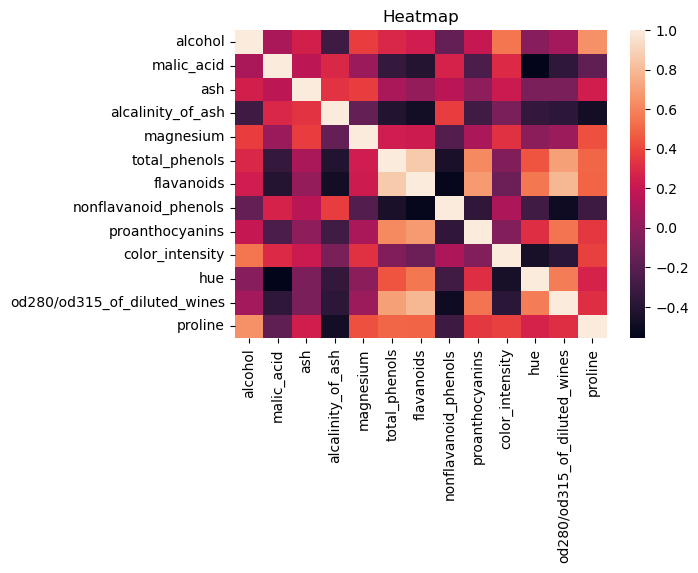

In [15]:
plt.figure(figsize=(6,4))

sns.heatmap(df_wine_corr)
plt.title('Heatmap')
plt.show()

In [16]:
def multicol(df):
    df_corr = df.corr()

    df_multicol = df_corr[(df_corr > 0.7) & (df_corr != 1.0)].notna().any()

    df = df.drop(columns=df_multicol[df_multicol==True].keys())

    return df

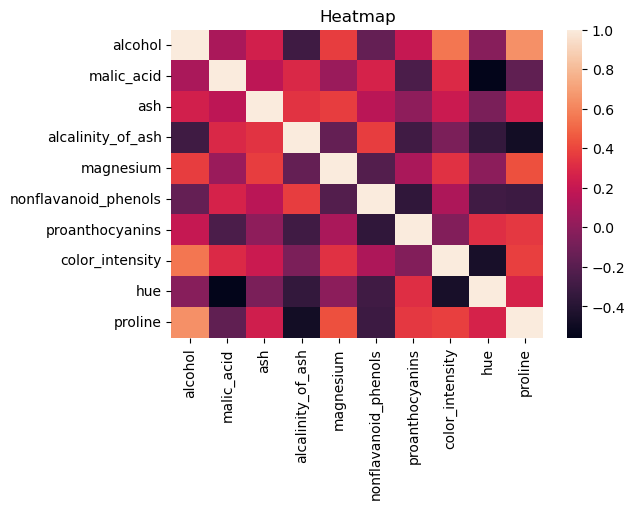

In [17]:
df_wine_multicol = multicol(df_wine)

plt.figure(figsize=(6,4))

sns.heatmap(df_wine_multicol.corr())
plt.title('Heatmap')
plt.show()

### Задание 3. Выбор наиболее значимых признаков.

Используйте набор данных "Boston Housing" из sklearn.datasets. Вычислите коэффициенты корреляции между каждым признаком и целевой переменной, затем выберите n признаков с наибольшим абсолютным значением коэффициента.

In [18]:
ds_housing = fetch_california_housing()

df_housing = pd.DataFrame(data=ds_housing.data, columns=ds_housing.feature_names)
df_housing['target'] = ds_housing.target 

df_housing.head(7)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992


In [19]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [20]:
df_housing.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

In [21]:
df_housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [22]:
anomalies_to_mean(df_housing)

df_housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.664336,28.639486,5.243510,1.051495,1238.073265,2.849463,35.631861,-119.569704,1.916827
std,1.464216,12.585558,1.140138,0.064958,624.518272,0.617234,2.135952,2.003532,0.929971
min,0.499900,1.000000,2.032738,0.866013,3.000000,1.161290,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.447368,1.007732,787.000000,2.430380,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.235714,1.050399,1166.000000,2.818868,34.260000,-118.490000,1.797000
75%,4.546100,37.000000,5.960233,1.096675,1559.000000,3.199720,37.710000,-118.010000,2.414000
max,8.011300,52.000000,8.469738,1.239521,3132.000000,4.560748,41.950000,-114.310000,4.822000


In [23]:
def max_corr(df, target):
    df['target'] = target

    correlations = df.corr()['target']
    correlations = correlations[correlations < 1.0].nlargest(3).index

    df = df[correlations]

    return df

df_housing_max_correlations = max_corr(df_housing.drop(columns=['target']), df_housing['target'])

df_housing_max_correlations.head(7)

,MedInc,AveRooms,HouseAge
0,3.870671,6.984127,41.0
1,3.870671,6.238137,21.0
2,7.257400,8.288136,52.0
3,5.643100,5.817352,52.0
4,3.846200,6.281853,52.0
5,4.036800,4.761658,52.0
6,3.659100,4.931907,52.0


### Задание 4. Применение ранговой корреляции Спирмена.
Используйте любой набор данных, имеющий порядковые признаки. Примените корреляцию Спирмена для выбора наиболее значимых признаков. Был использован [опрос о дезодоранте](https://www.kaggle.com/datasets/ramkumarr02/deodorant-instant-liking-data?select=Data_train_reduced.csv).

In [24]:
df_deodorant = pd.read_csv(r'Datasets/deodorant_survey.csv')

df_deodorant.head(7)

,Respondent_ID,Product_ID,Product,Instant_Liking,personal_opinion,q2.all.words,q3_1.strength.of.the.Deodorant,q4_1.artificial.chemical,q4_2.attractive,q4_3.bold,...,ValSegb,s7.involved.in.the.selection.of.the.cosmetic.products,s8.ethnic.background,s9.education,s10.income,s11.marital.status,s12.working.status,s13.2,s13a.b.most.often,s13b.bottles.of.Deodorant.do.you.currently.own
0,3800,121,Deodorant B,1,4,1,4,2,5,4,...,7,4,1,4,3,1,1,0.0,0,3
1,3801,121,Deodorant B,0,5,1,4,4,2,2,...,6,4,1,4,3,1,1,0.0,0,4
2,3802,121,Deodorant B,0,6,1,3,2,5,2,...,7,4,1,3,5,1,1,0.0,0,2
3,3803,121,Deodorant B,1,4,0,4,5,5,4,...,1,4,1,4,9,1,3,0.0,0,3
4,3804,121,Deodorant B,1,4,1,2,1,3,1,...,4,4,1,3,5,1,2,0.0,0,3
5,3805,121,Deodorant B,0,5,1,5,5,5,2,...,7,4,1,4,5,2,2,0.0,0,2
6,3806,121,Deodorant B,0,7,0,2,3,2,3,...,6,4,1,3,2,2,6,0.0,0,5


In [25]:
df_deodorant.columns

Index(['Respondent_ID', 'Product_ID', 'Product', 'Instant_Liking',
       'personal_opinion', 'q2.all.words', 'q3_1.strength.of.the.Deodorant',
       'q4_1.artificial.chemical', 'q4_2.attractive', 'q4_3.bold',
       'q4_4.boring', 'q4_5.casual', 'q4_6.cheap', 'q4_7.clean',
       'q4_8.easy.to.wear', 'q4_9.elegant', 'q4_10.feminine',
       'q4_11.for.someone.like.me', 'q4_12.heavy', 'q4_13.high.quality',
       'q4_14.long.lasting', 'q4_15.masculine', 'q4_16.memorable',
       'q4_17.natural', 'q4_18.old.fashioned', 'q4_19.ordinary',
       'q4_20.overpowering', 'q4_21.sharp', 'q4_22.sophisticated',
       'q4_23.upscale', 'q4_24.well.rounded', 'q5_1.Deodorant.is.addictive',
       'q7', 'q8.1', 'q8.2', 'q8.5', 'q8.6', 'q8.7', 'q8.8', 'q8.9', 'q8.10',
       'q8.11', 'q8.12', 'q8.13', 'q8.17', 'q8.18', 'q8.19', 'q8.20',
       'q9.how.likely.would.you.be.to.purchase.this.Deodorant',
       'q10.prefer.this.Deodorant.or.your.usual.Deodorant',
       'q11.time.of.day.would.this.Deodor

In [26]:
for i in range(5, len(df_deodorant.columns)):
    col = df_deodorant.columns[i]
    col1 = col.split(sep='.')

    if len(col) > 1:
        col1 = '_'.join(col1[1:])

    df_deodorant = df_deodorant.rename(columns={f'{col}':f'{col1}'})

df_deodorant.columns

Index(['Respondent_ID', 'Product_ID', 'Product', 'Instant_Liking',
       'personal_opinion', 'all_words', 'strength_of_the_Deodorant',
       'artificial_chemical', 'attractive', 'bold', 'boring', 'casual',
       'cheap', 'clean', 'easy_to_wear', 'elegant', 'feminine',
       'for_someone_like_me', 'heavy', 'high_quality', 'long_lasting',
       'masculine', 'memorable', 'natural', 'old_fashioned', 'ordinary',
       'overpowering', 'sharp', 'sophisticated', 'upscale', 'well_rounded',
       'Deodorant_is_addictive', '', '1', '2', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '17', '18', '19', '20',
       'how_likely_would_you_be_to_purchase_this_Deodorant',
       'prefer_this_Deodorant_or_your_usual_Deodorant',
       'time_of_day_would_this_Deodorant_be_appropriate',
       'which_occasions_would_this_Deodorant_be_appropriate',
       'after_30_minutes', 'Deodorant_overall_on_a_scale_from_1_to_10', '',
       'involved_in_the_selection_of_the_cosmetic_products',
       

In [27]:
df_deodorant = df_deodorant[['Respondent_ID', 'Instant_Liking', 'personal_opinion', 'strength_of_the_Deodorant',
       'artificial_chemical', 'attractive', 'bold', 'boring', 'casual',
       'cheap', 'clean', 'easy_to_wear', 'elegant', 'feminine',
       'for_someone_like_me', 'heavy', 'high_quality', 'long_lasting',
       'masculine', 'memorable', 'natural', 'old_fashioned', 'ordinary',
       'overpowering', 'sharp', 'sophisticated', 'upscale', 'well_rounded']]

df_deodorant.head(7)

,Respondent_ID,Instant_Liking,personal_opinion,strength_of_the_Deodorant,artificial_chemical,attractive,bold,boring,casual,cheap,...,masculine,memorable,natural,old_fashioned,ordinary,overpowering,sharp,sophisticated,upscale,well_rounded
0,3800,1,4,4,2,5,4,2,3,5,...,2,4,5,4,5,1,1,4,1,4
1,3801,0,5,4,4,2,2,1,3,2,...,4,5,3,3,4,2,2,5,4,4
2,3802,0,6,3,2,5,2,4,2,4,...,1,4,2,4,3,2,5,4,4,3
3,3803,1,4,4,5,5,4,3,5,2,...,3,5,5,4,2,5,3,3,5,4
4,3804,1,4,2,1,3,1,1,3,3,...,2,3,5,1,2,4,2,3,1,5
5,3805,0,5,5,5,5,2,1,4,5,...,2,3,4,2,2,3,1,5,5,4
6,3806,0,7,2,3,2,3,2,4,2,...,2,3,4,1,4,3,1,5,3,5


In [28]:
df_deodorant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Respondent_ID              2500 non-null   int64
 1   Instant_Liking             2500 non-null   int64
 2   personal_opinion           2500 non-null   int64
 3   strength_of_the_Deodorant  2500 non-null   int64
 4   artificial_chemical        2500 non-null   int64
 5   attractive                 2500 non-null   int64
 6   bold                       2500 non-null   int64
 7   boring                     2500 non-null   int64
 8   casual                     2500 non-null   int64
 9   cheap                      2500 non-null   int64
 10  clean                      2500 non-null   int64
 11  easy_to_wear               2500 non-null   int64
 12  elegant                    2500 non-null   int64
 13  feminine                   2500 non-null   int64
 14  for_someone_like_me     

In [29]:
df_deodorant.isna().sum()

Respondent_ID                0
Instant_Liking               0
personal_opinion             0
strength_of_the_Deodorant    0
artificial_chemical          0
attractive                   0
bold                         0
boring                       0
casual                       0
cheap                        0
clean                        0
easy_to_wear                 0
elegant                      0
feminine                     0
for_someone_like_me          0
heavy                        0
high_quality                 0
long_lasting                 0
masculine                    0
memorable                    0
natural                      0
old_fashioned                0
ordinary                     0
overpowering                 0
sharp                        0
sophisticated                0
upscale                      0
well_rounded                 0
dtype: int64

In [30]:
df_deodorant.describe()

,Respondent_ID,Instant_Liking,personal_opinion,strength_of_the_Deodorant,artificial_chemical,attractive,bold,boring,casual,cheap,...,masculine,memorable,natural,old_fashioned,ordinary,overpowering,sharp,sophisticated,upscale,well_rounded
count,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,8249.500000,0.24720,5.129600,3.344400,2.500000,3.71680,3.546000,2.241600,3.487200,2.347600,...,2.078400,3.826400,3.467200,2.62880,2.860000,2.978800,3.332400,3.635200,3.527600,3.648000
std,3433.008516,0.43147,1.481918,0.743243,1.384618,1.27548,1.261951,1.242838,1.276906,1.312198,...,1.272203,1.163789,1.278428,1.40876,1.301491,1.426031,1.306673,1.270735,1.281365,1.197276
min,3800.000000,0.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5324.750000,0.00000,5.000000,3.000000,1.000000,3.00000,3.000000,1.000000,3.000000,1.000000,...,1.000000,3.000000,3.000000,1.00000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000
50%,8249.500000,0.00000,5.000000,3.000000,2.000000,4.00000,4.000000,2.000000,4.000000,2.000000,...,2.000000,4.000000,4.000000,2.00000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000
75%,9774.250000,0.00000,6.000000,4.000000,4.000000,5.00000,5.000000,3.000000,5.000000,3.000000,...,3.000000,5.000000,5.000000,4.00000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000
max,14099.000000,1.00000,7.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


В качестве целевого значения в датасете выбрали параметр "Instant_Liking".

In [31]:
correlations = df_deodorant.drop(['Respondent_ID', 'Instant_Liking'], axis=1).apply(lambda x: x.corr(df_deodorant['Instant_Liking'], method='spearman'))

correlations = correlations.abs().sort_values(ascending=False)[:3]

df_deodorant[correlations.keys()]

,personal_opinion,high_quality,natural
0,4,5,5
1,5,3,3
2,6,1,2
3,4,4,5
4,4,4,5
...,...,...,...
2495,6,4,1
2496,5,3,5
2497,4,5,3
2498,5,5,2


### Задание 5. Сраните методы отбора признаков.

Используйте один и тот же набор данных для применения различных методов отбора признаков, включая корреляционные методы, и сравните результаты.

Это задание выполнено в лабораторной номер 6.

In [32]:
X = df_housing.drop(columns=['target']).astype(float)
y = df_housing['target'].astype(float)

max_corr(X, y)

,MedInc,AveRooms,HouseAge
0,3.870671,6.984127,41.0
1,3.870671,6.238137,21.0
2,7.257400,8.288136,52.0
3,5.643100,5.817352,52.0
4,3.846200,6.281853,52.0
...,...,...,...
20635,1.560300,5.045455,25.0
20636,2.556800,6.114035,18.0
20637,1.700000,5.205543,17.0
20638,1.867200,5.329513,18.0


MSE для Мультиколлинеарность: 0.40603651512079
MSE для Максимальная корреляция: 0.5372085746332483


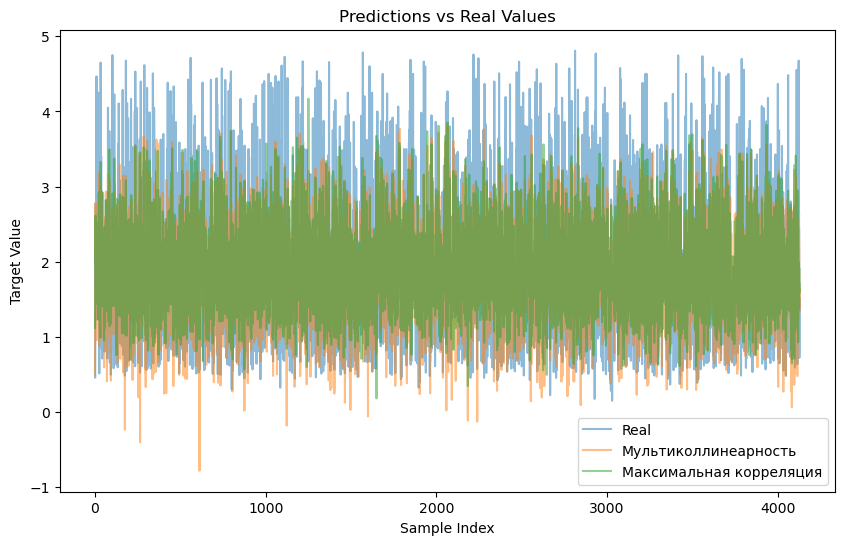

In [33]:
X = df_housing.drop(columns=['target']).astype(float)
y = df_housing['target'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

LR = LinearRegression()

feature_selection = {'Мультиколлинеарность': multicol(X),
                     'Максимальная корреляция': max_corr(X, y)}

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Real', alpha=0.5)

for features in feature_selection.keys():
    X_train, X_test, y_train, y_test = train_test_split(feature_selection[features], y, test_size=0.2, random_state=42)

    LR.fit(X_train, y_train)
    
    predictions = LR.predict(X_test)

    plt.plot(predictions, label=f'{features}', alpha=0.5)
    plt.title('Predictions vs Real Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Target Value')
    plt.legend()

    mse = mean_squared_error(y_test, predictions)
    print(f"MSE для {features}: {mse}")

plt.show()

### Задание 6. Исследование влияния предобработки данных на результаты корреляционного анализа.

Примените различные методы предобработки (например, нормализацию, стандартизацию, логарифмирование) к данным перед вычислением корреляции и сравните полученные результаты.

In [34]:
df_iris['target'] = ds_iris.target_names[ds_iris.target[:, None]]

df_iris.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa


In [35]:
df_iris_log = pd.DataFrame(data=np.log(df_iris.drop(columns=['target']) + 1), columns=df_iris.drop(columns=['target']).columns)
df_iris_log['target'] = df_iris['target']

df_iris_log.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,1.808289,1.504077,0.875469,0.182322,setosa
1,1.774952,1.386294,0.875469,0.182322,setosa
2,1.740466,1.435085,0.832909,0.182322,setosa
3,1.722767,1.410987,0.916291,0.182322,setosa
4,1.791759,1.526056,0.875469,0.182322,setosa
5,1.856298,1.589235,0.993252,0.336472,setosa
6,1.722767,1.481605,0.875469,0.262364,setosa


In [36]:
sc = StandardScaler()
sc.fit(df_iris.drop(columns=['target']))

df_iris_standard = pd.DataFrame(data=sc.transform(df_iris.drop(columns=['target'])), columns=df_iris.drop(columns=['target']).columns)
df_iris_standard['target'] = df_iris['target']

df_iris_standard.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,-0.900681,1.17374,-1.340227,-1.315444,setosa
1,-1.143017,-0.10446,-1.340227,-1.315444,setosa
2,-1.385353,0.40682,-1.397064,-1.315444,setosa
3,-1.506521,0.15118,-1.283389,-1.315444,setosa
4,-1.021849,1.42938,-1.340227,-1.315444,setosa


In [37]:
nc = MinMaxScaler()
nc.fit(df_iris.drop(columns=['target']))

df_iris_normal = pd.DataFrame(data=nc.transform(df_iris.drop(columns=['target'])), columns=df_iris.drop(columns=['target']).columns)
df_iris_normal['target'] = df_iris['target']

df_iris_normal.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,0.222222,0.722222,0.067797,0.041667,setosa
1,0.166667,0.444444,0.067797,0.041667,setosa
2,0.111111,0.555556,0.050847,0.041667,setosa
3,0.083333,0.500000,0.084746,0.041667,setosa
4,0.194444,0.777778,0.067797,0.041667,setosa


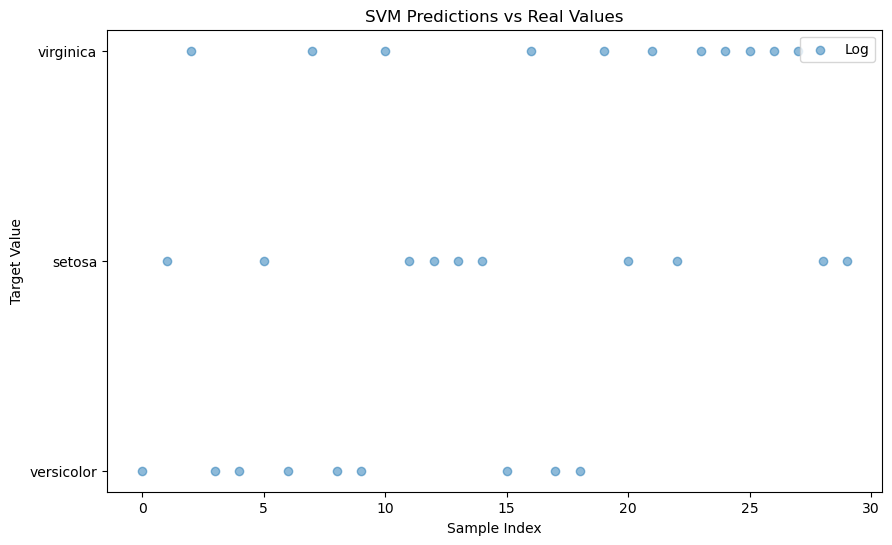

Accuracy for Log: 1.0
Precision for Log: 1.0
Recall for Log: 1.0


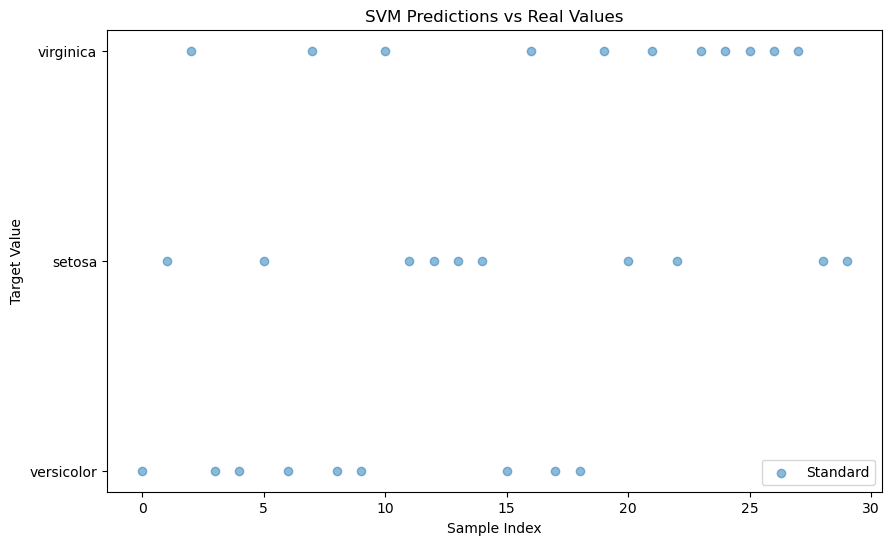

Accuracy for Standard: 1.0
Precision for Standard: 1.0
Recall for Standard: 1.0


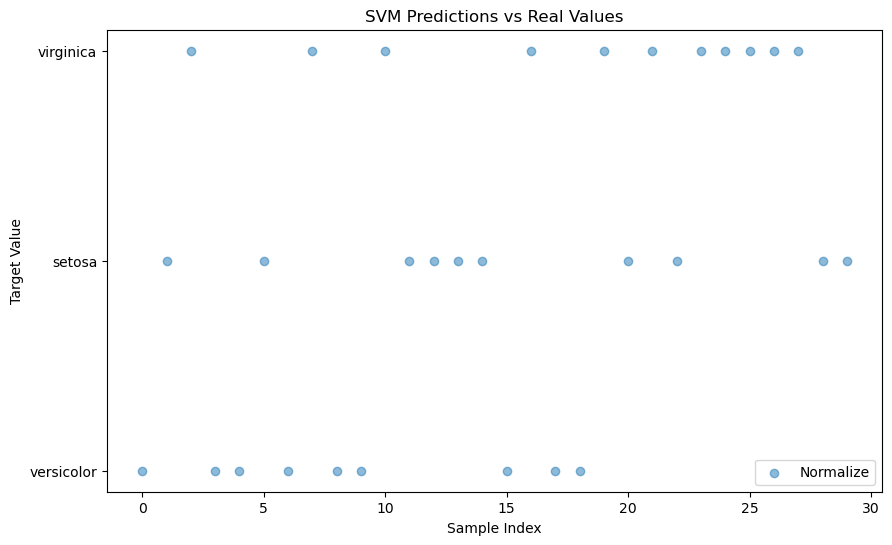

Accuracy for Normalize: 1.0
Precision for Normalize: 1.0
Recall for Normalize: 1.0


In [38]:
svm = SVC()

dict_preprocessing = {'Log': df_iris_log,
                      'Standard': df_iris_standard, 
                      'Normalize': df_iris_normal}

for prep in dict_preprocessing.keys():
    data = dict_preprocessing[prep]

    X = data.drop(columns='target')
    y = data['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    plt.figure(figsize=(10, 6))

    plt.scatter(range(len(y_pred)), y_pred, label=f'{prep}', alpha=0.5)

    plt.title('SVM Predictions vs Real Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()  

    print(f"Accuracy for {prep}: {accuracy}")
    print(f'Precision for {prep}: {precision}')
    print(f'Recall for {prep}: {recall}')



## Методы-обертки.
### Задание 1. Рекурсивное исключение признаков (RFE).
Используйте набор данных "Iris" из sklearn.datasets. Примените метод RFE с использованием модели логистической регрессии. Укажите количество признаков для выбора и сравните производительность модели с и без этих признаков.

In [39]:
X = df_iris.drop(columns=['target'])
y = ds_iris['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

LR = LinearRegression()
rfe = RFE(LR, n_features_to_select=2)

rfe.fit(X_train, y_train)

rfe_features = X.columns[rfe.support_]
print(rfe_features)

Index(['petal length (cm)', 'petal width (cm)'], dtype='object')


In [40]:
LR.fit(X_train[rfe_features], y_train)
predictions = LR.predict(X_test[rfe_features])
mse = mean_squared_error(predictions, y_test)
print(f'MSE без признаков: {mse}')

LR.fit(X_train, y_train)
predictions = LR.predict(X_test)
mse = mean_squared_error(predictions, y_test)
print(f'MSE с признаками: {mse}')

MSE без признаков: 0.03512954961503085
MSE с признаками: 0.03808044798748589


### Задание 2. Sequential Feature Selector.
Используйте набор данных "Boston Housing" из sklearn.datasets. Используйте Sequential Feature Selector для выбора признаков с использованием модели Random Forest. Визуализируйте "важность" признаков.

In [41]:
ds_housing = fetch_california_housing()

df_housing = pd.DataFrame(data=ds_housing.data, columns=ds_housing.feature_names)
df_housing['target'] = ds_housing.target

df_housing.head(7)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992


In [42]:
df_housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [43]:
X, y = df_housing.drop(columns=['target'])[:500], df_housing['target'][:500]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

rfr = RandomForestRegressor()
sfs = SequentialFeatureSelector(rfr, n_features_to_select=3)
sfs.fit(X_train, y_train)

sfs_features = X.columns[sfs.support_]
print(sfs_features)

Index(['MedInc', 'Latitude', 'Longitude'], dtype='object')


Признак: MedInc, Важность: 0.6673985922423644
Признак: Latitude, Важность: 0.22542166206433598
Признак: Longitude, Важность: 0.10717974569329955


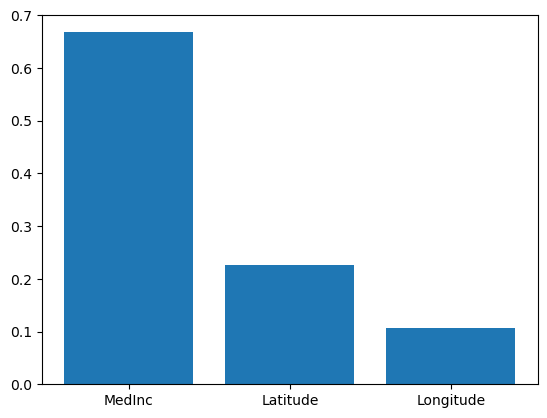

In [44]:
rfr.fit(X_train[sfs_features], y_train)
feature_importances = rfr.feature_importances_

feature_importance_dict = dict(zip(X_train[sfs_features].columns, feature_importances))

sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_features:
    print(f'Признак: {feature}, Важность: {importance}')

x = np.array([0, 1, 2])
pyplot.bar([y for y in range(len(feature_importances))], feature_importances)
plt.xticks(x, sfs_features)
pyplot.show()

### Задание 3. Использование метода-обертки при кросс-валидации.
Используйте любой набор данных на ваше усмотрение. Выберите модель машинного обучения и метод-обертку для отбора признаков. Примените кросс-валидацию, чтобы оценить эффективность этого подхода.

In [63]:
X, y = df_iris.drop(columns=['target']), df_iris['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

sfs = SequentialFeatureSelector(rfc, n_features_to_select=3)
sfs.fit(X_train, y_train)

sfs_features = X.columns[sfs.support_]

cv = RepeatedStratifiedKFold(n_splits=5)

scores = cross_val_score(rfc, X_test[sfs_features], y_test, scoring='accuracy', cv=cv, n_jobs=-1)
mean_accuracy = np.mean(scores)

print(mean_accuracy)

0.9633333333333334


### Задание 4. Сравнение методов-оберток.
Используйте один и тот же набор данных для применения различных методов-оберток для отбора признаков, например, RFE и Sequential Feature Selector, и сравните полученные результаты.

In [62]:
rfe = RFE(rfc, n_features_to_select=3)

rfe.fit(X_train, y_train)

rfe_features = X.columns[rfe.support_]

print('Признаки, отобранные через RFE: ', rfe_features)
print('Признаки, отобранные Sequential Feature Selection: ', sfs_features)

Признаки, отобранные через RFE:  Index(['sepal length (cm)', 'petal length (cm)', 'petal width (cm)'], dtype='object')
Признаки, отобранные Sequential Feature Selection:  Index(['sepal length (cm)', 'petal length (cm)', 'petal width (cm)'], dtype='object')


In [64]:
scores_rfe = cross_val_score(rfc, X_test[rfe_features], y_test, scoring='accuracy', cv=cv, n_jobs=-1)
mean_accuracy_rfe = np.mean(scores_rfe)

scores_sfs = cross_val_score(rfc, X_test[sfs_features], y_test, scoring='accuracy', cv=cv, n_jobs=-1)
mean_accuracy_sfs = np.mean(scores_sfs)

print('Результат кросс-валидации для RFE: ', mean_accuracy_rfe)
print('Результат кросс-валидации для Sequential Feature Selection: ', mean_accuracy_sfs)

Результат кросс-валидации для RFE:  0.9666666666666667
Результат кросс-валидации для Sequential Feature Selection:  0.9633333333333334


### Задание 5.  Анализ предсказательной способности признаков.
Используйте набор данных "Wine" из sklearn.datasets. Выберите модель машинного обучения и метод-обертку для отбора признаков и исследуйте, как влияет отбор признаков на предсказательную способность модели.

In [66]:
X, y = df_wine, ds_wine['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfe = RFE(LR, n_features_to_select=5)
rfe.fit(X_train, y_train)

rfe_features = X.columns[rfe.support_]

print(rfe_features)

Index(['alcohol', 'total_phenols', 'flavanoids', 'hue',
       'od280/od315_of_diluted_wines'],
      dtype='object')


In [72]:
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

LR.fit(X_train[rfe_features], y_train)
y_pred_rfe = LR.predict(X_test[rfe_features])

print('MSE без отбора признаков: ', mean_squared_error(y_test, y_pred))
print('MSE с отбором признаков: ', mean_squared_error(y_test, y_pred_rfe))

MSE без отбора признаков:  0.06470981692403452
MSE с отбором признаков:  0.09386984930486494


In [78]:
scores_rfe = cross_val_score(LR, X_test[rfe_features], y_test, scoring='explained_variance', cv=cv, n_jobs=-1)
mean_accuracy_rfe = np.mean(scores_rfe)

scores = cross_val_score(LR, X_test, y_test, scoring='explained_variance', cv=cv, n_jobs=-1)
mean_accuracy = np.mean(scores)

print('Результат кросс-валидации для RFE: ', mean_accuracy_rfe)
print('Результат кросс-валидации: ', mean_accuracy)

Результат кросс-валидации для RFE:  0.8221209523113212
Результат кросс-валидации:  0.7173058582424775
